# Lab 3: Gesture Recognition using Convolutional Neural Networks

In this lab you will train a convolutional neural network to make classifications on different hand gestures. By the end of the lab, you should be able to:

1. Load and split data for training, validation and testing
2. Train a Convolutional Neural Network
3. Apply transfer learning to improve your model

Note that for this lab we will not be providing you with any starter code. You should be able to take the code used in previous labs, tutorials and lectures and modify it accordingly to complete the tasks outlined below.

### What to submit

Submit a PDF file containing all your code, outputs, and write-up
from parts 1-5. You can produce a PDF of your Google Colab file by
going to **File > Print** and then save as PDF. The Colab instructions
has more information. Make sure to review the PDF submission to ensure that your answers are easy to read. Make sure that your text is not cut off at the margins.

**Do not submit any other files produced by your code.**

Include a link to your colab file in your submission.

Please use Google Colab to complete this assignment. If you want to use Jupyter Notebook, please complete the assignment and upload your Jupyter Notebook file to Google Colab for submission.

## Colab Link

Include a link to your colab file here

Colab Link: https://colab.research.google.com/drive/1KHBHaXkiEX53hvdzM5DY-tcoRxoHM5dI?usp=sharing

## Dataset

American Sign Language (ASL) is a complete, complex language that employs signs made by moving the
hands combined with facial expressions and postures of the body. It is the primary language of many
North Americans who are deaf and is one of several communication options used by people who are deaf or
hard-of-hearing. The hand gestures representing English alphabet are shown below. This lab focuses on classifying a subset
of these hand gesture images using convolutional neural networks. Specifically, given an image of a hand
showing one of the letters A-I, we want to detect which letter is being represented.

![alt text](https://www.disabled-world.com/pics/1/asl-alphabet.jpg)

## Part B. Building a CNN [50 pt]

For this lab, we are not going to give you any starter code. You will be writing a convolutional neural network
from scratch. You are welcome to use any code from previous labs, lectures and tutorials. You should also
write your own code.

You may use the PyTorch documentation freely. You might also find online tutorials helpful. However, all
code that you submit must be your own.

Make sure that your code is vectorized, and does not contain obvious inefficiencies (for example, unecessary
for loops, or unnecessary calls to unsqueeze()). Ensure enough comments are included in the code so that
your TA can understand what you are doing. It is your responsibility to show that you understand what you
write.

**This is much more challenging and time-consuming than the previous labs.** Make sure that you
give yourself plenty of time by starting early.

### 1. Data Loading and Splitting [5 pt]

Download the anonymized data provided on Quercus. To allow you to get a heads start on this project we will provide you with sample data from previous years. Split the data into training, validation, and test sets.

Note: Data splitting is not as trivial in this lab. We want our test set to closely resemble the setting in which
our model will be used. In particular, our test set should contain hands that are never seen in training!

Explain how you split the data, either by describing what you did, or by showing the code that you used.
Justify your choice of splitting strategy. How many training, validation, and test images do you have?

For loading the data, you can use plt.imread as in Lab 1, or any other method that you choose. You may find
torchvision.datasets.ImageFolder helpful. (see https://pytorch.org/docs/stable/torchvision/datasets.html?highlight=image%20folder#torchvision.datasets.ImageFolder
)

In [ ]:
#Importing libraries
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import TensorDataset
import numpy as np
import matplotlib.pyplot as plt

#importing access to google drive
from google.colab import drive
drive.mount('/content/gdrive')

#connecting to drive
master_path = '/content/gdrive/My Drive/APS360/Lab3_Gestures_Summer/'

In [ ]:
use_cuda = True

In [ ]:
# Data loading and splitting

# Data Loading and Splitting
np.random.seed(1000)
indices = list(range(400, 920))
chosen_indices = np.random.choice(indices, (2, 230), replace=False)

def train_valid_file(filename):
    val_file = any(student in filename for student in chosen_indices.astype(str)[0])
    test_file = any(student in filename for student in chosen_indices.astype(str)[1])
    train_file = not(val_file or test_file)
    return train_file

def val_valid_file(filename):
    val_file = any(student in filename for student in chosen_indices.astype(str)[0])
    test_file = any(student in filename for student in chosen_indices.astype(str)[1])
    train_file = not(val_file or test_file)
    return val_file

def test_valid_file(filename):
    val_file = any(student in filename for student in chosen_indices.astype(str)[0])
    test_file = any(student in filename for student in chosen_indices.astype(str)[1])
    train_file = not(val_file or test_file)
    return test_file

transform = transforms.Compose([transforms.ToPILImage(),transforms.Resize((224,224)),
                                transforms.ToTensor()])

#transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

train_data = torchvision.datasets.ImageFolder(master_path, loader=plt.imread, is_valid_file=train_valid_file, transform=transform)
val_data = torchvision.datasets.ImageFolder(master_path, loader=plt.imread, is_valid_file=val_valid_file, transform=transform)
test_data = torchvision.datasets.ImageFolder(master_path, loader=plt.imread, is_valid_file=test_valid_file, transform=transform)

total_data = len(train_data) + len(val_data) + len(test_data)

print("The number of training images is", len(train_data), ", which is", len(train_data)/total_data*100, "% of the entire dataset.")
print("The number of validation images is", len(val_data), ", which is", len(val_data)/total_data*100, "% of the entire dataset.")
print("The number of test images is", len(test_data), ", which is", len(test_data)/total_data*100, "% of the entire dataset.")



The number of training images is 1351 , which is 60.15138023152271 % of the entire dataset.
The number of validation images is 447 , which is 19.90204808548531 % of the entire dataset.
The number of test images is 448 , which is 19.946571682991987 % of the entire dataset.


**The dataset has been split so 60% of the data is training data and approximately 20% of the data is validation and testing images**

### 2. Model Building and Sanity Checking [15 pt]

### Part (a) Convolutional Network - 5 pt

Build a convolutional neural network model that takes the (224x224 RGB) image as input, and predicts the gesture
letter. Your model should be a subclass of nn.Module. Explain your choice of neural network architecture: how
many layers did you choose? What types of layers did you use? Were they fully-connected or convolutional?
What about other decisions like pooling layers, activation functions, number of channels / hidden units?

In [ ]:
#Creation of CNN
torch.manual_seed(1)
class CNNClassifier(nn.Module):
    def __init__(self):

        super(CNNClassifier, self).__init__()
        self.name = "CNNModel"
        self.conv1 = nn.Conv2d(3, 5, 5) #3 channels in, 5 channels out, kernal size 5
        self.pool = nn.MaxPool2d(2, 2) #Kernel size 2 and stride size 2
        self.conv2 = nn.Conv2d(5, 10, 5) #channel size in = 5, channel size out = 10, kernel size = 5
        self.fc1 = nn.Linear(10 * 53 * 53, 400)
        self.fc2 = nn.Linear(400, 10)

    def forward(self, img):
        x = self.pool(F.relu(self.conv1(img)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 10 * 53 * 53)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

### Part (b) Training Code - 5 pt

Write code that trains your neural network given some training data. Your training code should make it easy
to tweak the usual hyperparameters, like batch size, learning rate, and the model object itself. Make sure
that you are checkpointing your models from time to time (the frequency is up to you). Explain your choice
of loss function and optimizer.

In [ ]:
def get_accuracy(model, train_loader, val_loader, train=False):
    if train:
        data = train_loader
    else:
        data = val_loader

    correct = 0
    total = 0

    for imgs, labels in data:
        #To Enable GPU Usage
        if use_cuda and torch.cuda.is_available():
          imgs = imgs.cuda()
          labels = labels.cuda()

        output = model(imgs)

        #select index with maximum prediction score
        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += imgs.shape[0]
    return correct / total

In [ ]:
def train(model, train_data, val_data, learning_rate = 0.001, batch_size = 30, num_epochs = 1):
    torch.manual_seed(1000)
    train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle = True)
    val_loader = torch.utils.data.DataLoader(val_data, batch_size = batch_size, shuffle = True )
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

    iters, losses, train_acc, val_acc = [], [], [], []

    # training
    epoch = 0 # the number of iterations
    for epoch in range(num_epochs):
        for imgs, labels in iter(train_loader):

            #To Enable GPU Usage
            if use_cuda and torch.cuda.is_available():
              imgs = imgs.cuda()
              labels = labels.cuda()

            out = model(imgs)             # forward pass

            loss = criterion(out, labels) # compute the total loss
            loss.backward()               # backward pass (compute parameter updates)
            optimizer.step()              # make the updates for each parameter
            optimizer.zero_grad()         # a clean up step for PyTorch

        iters.append(epoch)
        losses.append(float(loss)/batch_size)             # compute *average* loss
        train_acc.append(get_accuracy(model, train_loader, val_loader, train=True)) # compute training accuracy
        print("epoch number ", epoch+1, "accuracy: ",train_acc[epoch])
        val_acc.append(get_accuracy(model, train_loader, val_loader, train=False))  # compute validation accuracy
        model_path = "model_{0}_bs{1}_lr{2}_epoch{3}".format(model.name, batch_size, learning_rate, epoch)
        torch.save(model.state_dict(), model_path)

    # plotting
    plt.title("Training Curve")
    plt.plot(iters, losses, label="Train")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.show()

    plt.title("Training Curve")
    plt.plot(iters, train_acc, label="Train")
    plt.plot(iters, val_acc, label="Validation")
    plt.xlabel("Iterations")
    plt.ylabel("Training Accuracy")
    plt.legend(loc='best')
    plt.show()

    print("Final Training Accuracy: {}".format(train_acc[-1]))
    print("Final Validation Accuracy: {}".format(val_acc[-1]))


### Part (c) “Overfit” to a Small Dataset - 5 pt

One way to sanity check our neural network model and training code is to check whether the model is capable
of “overfitting” or “memorizing” a small dataset. A properly constructed CNN with correct training code
should be able to memorize the answers to a small number of images quickly.

Construct a small dataset (e.g. just the images that you have collected). Then show that your model and
training code is capable of memorizing the labels of this small data set.

With a large batch size (e.g. the entire small dataset) and learning rate that is not too high, You should be
able to obtain a 100% training accuracy on that small dataset relatively quickly (within 200 iterations).

In [ ]:
def get_small_accuracy(model, small_data_loader):
    data = small_data_loader

    correct = 0
    total = 0
    for imgs, labels in data:



        #To Enable GPU Usage
        if use_cuda and torch.cuda.is_available():
          imgs = imgs.cuda()
          labels = labels.cuda()



        output = model(imgs)

        #select index with maximum prediction score
        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += imgs.shape[0]

    return correct / total

In [ ]:
def train_small_overfit(model, batch_size=30, num_epochs=1, learning_rate = 0.001):
    #train_loader = torch.utils.data.DataLoader(data, batch_size=batch_size)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

    iters, losses, train_acc = [], [], []

    small_data_loader = torch.utils.data.DataLoader(small_data_set, batch_size=30,
                                              shuffle=True)
    #Training
    epoch = 0
    for epoch in range(num_epochs):
        for imgs, labels in iter(small_data_loader):

            #To Enable GPU Usage
            if use_cuda and torch.cuda.is_available():
              imgs = imgs.cuda()
              labels = labels.cuda()

            out = model(imgs)             # forward pass
            loss = criterion(out, labels) # compute the total loss
            loss.backward()               # backward pass (compute parameter updates)
            optimizer.step()              # make the updates for each parameter
            optimizer.zero_grad()         # a clean up step for PyTorch

        #Keep Current Training Info
        iters.append(epoch)
        losses.append(float(loss)/batch_size)             # compute *average* loss
        train_acc.append(get_small_accuracy(model, small_data_loader)) # compute training accuracy
        print("epoch number ", epoch+1, "accuracy: ",train_acc[epoch])
        if get_small_accuracy(model, small_data_loader) == 1:
          break
  # plotting
    plt.title("Training Curve")
    plt.plot(iters, losses, label="Train")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.show()

    plt.title("Training Curve")
    plt.plot(iters, train_acc, label="Train")
    plt.xlabel("Iterations")
    plt.ylabel("Training Accuracy")
    plt.legend(loc='best')
    plt.show()

    print("Final Training Accuracy: {}".format(train_acc[-1]))



CUDA is not available.  Training on CPU ...
epoch number  1 accuracy:  0.1111111111111111
epoch number  2 accuracy:  0.1111111111111111
epoch number  3 accuracy:  0.1111111111111111
epoch number  4 accuracy:  0.1111111111111111
epoch number  5 accuracy:  0.1111111111111111
epoch number  6 accuracy:  0.1111111111111111
epoch number  7 accuracy:  0.1111111111111111
epoch number  8 accuracy:  0.1111111111111111
epoch number  9 accuracy:  0.1111111111111111
epoch number  10 accuracy:  0.1111111111111111
epoch number  11 accuracy:  0.18518518518518517
epoch number  12 accuracy:  0.2222222222222222
epoch number  13 accuracy:  0.2222222222222222
epoch number  14 accuracy:  0.18518518518518517
epoch number  15 accuracy:  0.18518518518518517
epoch number  16 accuracy:  0.1111111111111111
epoch number  17 accuracy:  0.1111111111111111
epoch number  18 accuracy:  0.1111111111111111
epoch number  19 accuracy:  0.1111111111111111
epoch number  20 accuracy:  0.1111111111111111
epoch number  21 accur

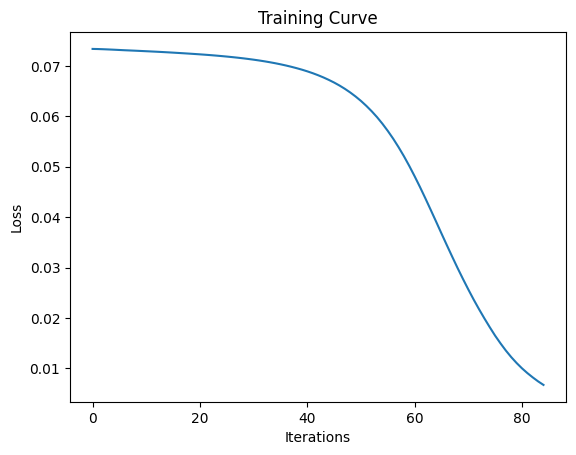

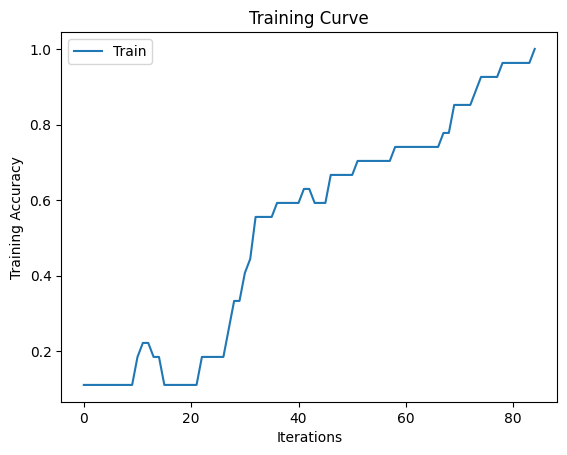

Final Training Accuracy: 1.0


In [ ]:
#Obtain small dataset
small_data_path = '/content/gdrive/My Drive/APS360/Lab3_Gestures_Summer/small_data_set'

# Transform Settings
transform = transforms.Compose([transforms.Resize((224,224)),
                                transforms.ToTensor()])

small_data_set = torchvision.datasets.ImageFolder(small_data_path, transform=transform)

classes = ['A' , 'B' , 'C' , 'D', 'E', 'F', 'G', 'H', 'I']

model = CNNClassifier()

if use_cuda and torch.cuda.is_available():
  model.cuda()
  print('CUDA is available!')
else:
  print('CUDA is not available')

#proper model
train_small_overfit(model, num_epochs=200)


### 3. Hyperparameter Search [10 pt]

### Part (a) - 1 pt

List 3 hyperparameters that you think are most worth tuning. Choose at least one hyperparameter related to
the model architecture.

**3 Hyperparameters that are worth tuning are the number of layers in the CNN, the learning rate and the batch size. As seen through the previous lab these factors tend to affect the models accuracy more than others.**

### Part (b) - 5 pt

Tune the hyperparameters you listed in Part (a), trying as many values as you need to until you feel satisfied
that you are getting a good model. Plot the training curve of at least 4 different hyperparameter settings.

CUDA is not available
epoch number  1 accuracy:  0.10510732790525537
epoch number  2 accuracy:  0.22131754256106587
epoch number  3 accuracy:  0.307920059215396
epoch number  4 accuracy:  0.5159141376757957
epoch number  5 accuracy:  0.2546262028127313
epoch number  6 accuracy:  0.4789045151739452
epoch number  7 accuracy:  0.5780903034789046
epoch number  8 accuracy:  0.6306439674315322
epoch number  9 accuracy:  0.5492227979274611
epoch number  10 accuracy:  0.616580310880829
epoch number  11 accuracy:  0.7017024426350851
epoch number  12 accuracy:  0.6084381939304219
epoch number  13 accuracy:  0.6750555144337528
epoch number  14 accuracy:  0.6313841598815693
epoch number  15 accuracy:  0.7202072538860104
epoch number  16 accuracy:  0.6602516654330126
epoch number  17 accuracy:  0.7194670614359734
epoch number  18 accuracy:  0.7357512953367875
epoch number  19 accuracy:  0.7446336047372317
epoch number  20 accuracy:  0.7253886010362695
epoch number  21 accuracy:  0.7113249444855663


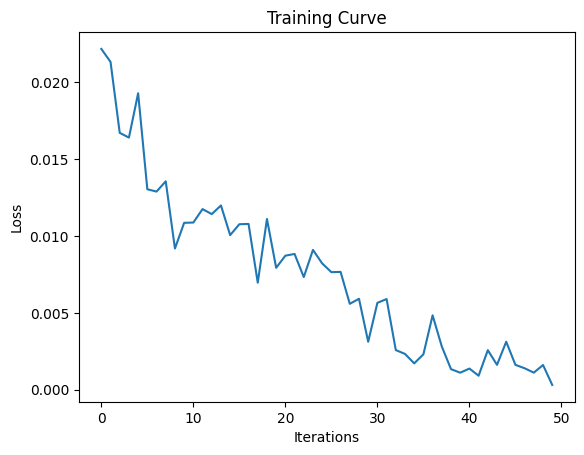

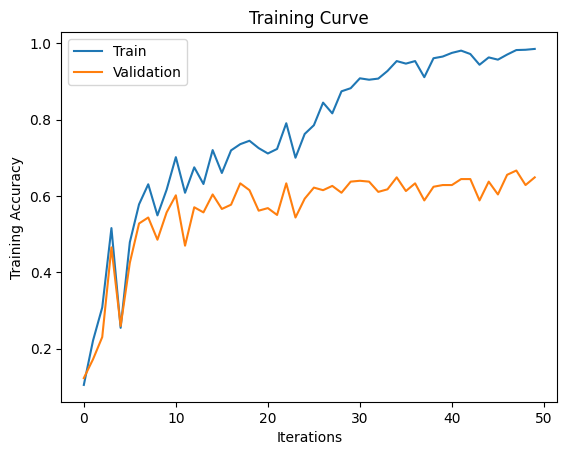

Final Training Accuracy: 0.9851961509992598
Final Validation Accuracy: 0.6487695749440716


In [ ]:
#For GPU Usage
use_cuda = True
model = CNNClassifier()
if use_cuda and torch.cuda.is_available():
  model.cuda()
else:
  print('CUDA is not available')

#Starting with a Default Model
train(model, train_data, val_data, learning_rate = 0.01, batch_size = 100, num_epochs = 50)

CUDA is not available
epoch number  1 accuracy:  0.10510732790525537
epoch number  2 accuracy:  0.11028867505551443
epoch number  3 accuracy:  0.11102886750555144
epoch number  4 accuracy:  0.1154700222057735
epoch number  5 accuracy:  0.11102886750555144
epoch number  6 accuracy:  0.10954848260547742
epoch number  7 accuracy:  0.28941524796447077
epoch number  8 accuracy:  0.20207253886010362
epoch number  9 accuracy:  0.28941524796447077
epoch number  10 accuracy:  0.5536639526276832
epoch number  11 accuracy:  0.5573649148778682
epoch number  12 accuracy:  0.6794966691339749
epoch number  13 accuracy:  0.692079940784604
epoch number  14 accuracy:  0.8349370836417469
epoch number  15 accuracy:  0.6106587712805329
epoch number  16 accuracy:  0.927461139896373
epoch number  17 accuracy:  0.9059955588452998
epoch number  18 accuracy:  0.9104367135455218
epoch number  19 accuracy:  0.9459659511472983
epoch number  20 accuracy:  0.9489267209474463
epoch number  21 accuracy:  0.98371576609

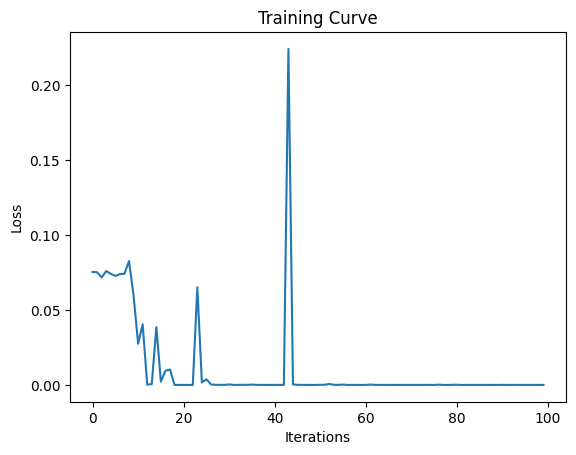

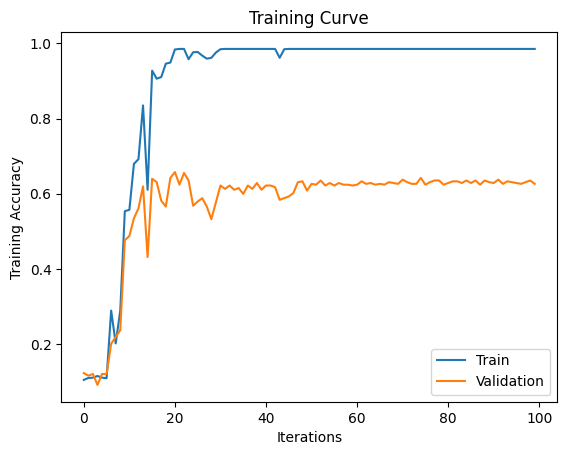

Final Training Accuracy: 0.9851961509992598
Final Validation Accuracy: 0.6263982102908278


In [ ]:
#For GPU Usage
use_cuda = True
model = CNNClassifier()
if use_cuda and torch.cuda.is_available():
  model.cuda()
else:
  print('CUDA is not available')

#Starting with a Default Model
train(model, train_data, val_data, learning_rate = 0.005, batch_size = 30, num_epochs = 100)

In [ ]:
#Creation of CNN
torch.manual_seed(1)
class CNN_Updated(nn.Module):
    def __init__(self):

        super(CNN_Updated, self).__init__()
        self.name = "CNN_Updated"
        self.conv1 = nn.Conv2d(3, 5, 5) #3 channels in, 5 channels out, kernal size 5
        self.pool = nn.MaxPool2d(2, 2) #Kernel size 2 and stride size 2
        self.conv2 = nn.Conv2d(5, 10, 5) #channel size in = 5, channel size out = 10, kernel size = 5
        self.fc1 = nn.Linear(10 * 53 * 53, 600)
        self.fc2 = nn.Linear(600, 90 ) #Extra layer added
        self.fc3 = nn.Linear(90 , 10)

    def forward(self, img):
        x = self.pool(F.relu(self.conv1(img)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 10 * 53 * 53)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

CUDA is not available
epoch number  1 accuracy:  0.22131754256106587
epoch number  2 accuracy:  0.28275351591413767
epoch number  3 accuracy:  0.5092524056254626
epoch number  4 accuracy:  0.5284974093264249
epoch number  5 accuracy:  0.5588452997779423
epoch number  6 accuracy:  0.7401924500370096
epoch number  7 accuracy:  0.7668393782383419
epoch number  8 accuracy:  0.8297557364914878
epoch number  9 accuracy:  0.8267949666913398
epoch number  10 accuracy:  0.7698001480384901
epoch number  11 accuracy:  0.8815692079940785
epoch number  12 accuracy:  0.8948926720947447
epoch number  13 accuracy:  0.9430051813471503
epoch number  14 accuracy:  0.8786084381939304
epoch number  15 accuracy:  0.9326424870466321
epoch number  16 accuracy:  0.9393042190969653
epoch number  17 accuracy:  0.9585492227979274
epoch number  18 accuracy:  0.9430051813471503
epoch number  19 accuracy:  0.764618800888231
epoch number  20 accuracy:  0.8460399703923019
epoch number  21 accuracy:  0.9437453737971873

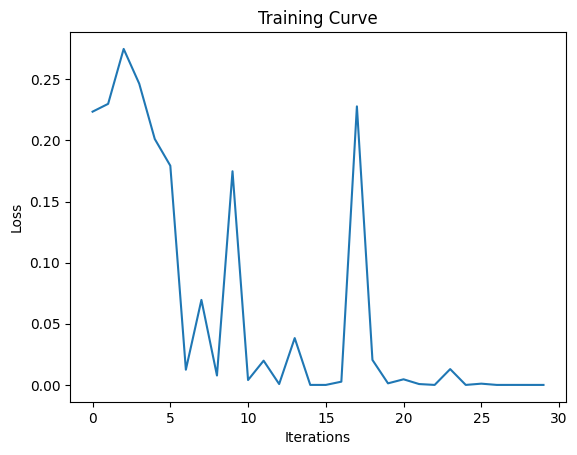

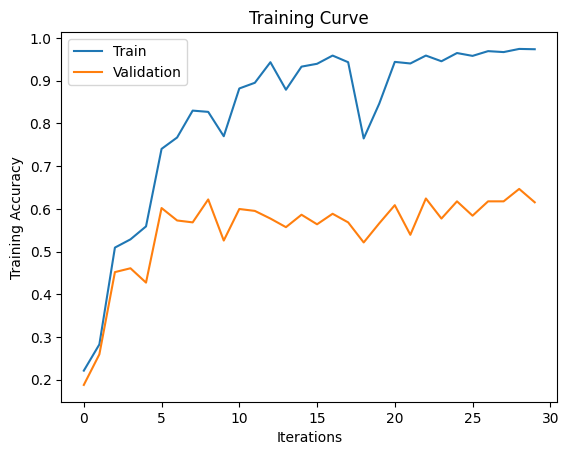

Final Training Accuracy: 0.9733530717986677
Final Validation Accuracy: 0.6152125279642058


In [ ]:
#For GPU Usage
use_cuda = True
model = CNN_Updated()
if use_cuda and torch.cuda.is_available():
  model.cuda()
else:
  print('CUDA is not available')

#Starting with a Default Model
train(model, train_data, val_data, learning_rate = 0.001, batch_size = 10, num_epochs = 30)

CUDA is not available
epoch number  1 accuracy:  0.15173945225758698
epoch number  2 accuracy:  0.17986676535899335
epoch number  3 accuracy:  0.2161361954108068
epoch number  4 accuracy:  0.2524056254626203
epoch number  5 accuracy:  0.40562546262028126
epoch number  6 accuracy:  0.43449296817172467
epoch number  7 accuracy:  0.4966691339748335
epoch number  8 accuracy:  0.538860103626943
epoch number  9 accuracy:  0.5492227979274611
epoch number  10 accuracy:  0.6299037749814952
epoch number  11 accuracy:  0.6476683937823834
epoch number  12 accuracy:  0.6861584011843079
epoch number  13 accuracy:  0.7113249444855663
epoch number  14 accuracy:  0.7216876387860843
epoch number  15 accuracy:  0.7638786084381939
epoch number  16 accuracy:  0.7520355292376018
epoch number  17 accuracy:  0.7557364914877869
epoch number  18 accuracy:  0.8053293856402665
epoch number  19 accuracy:  0.8016284233900814
epoch number  20 accuracy:  0.8275351591413768
epoch number  21 accuracy:  0.80384900074019

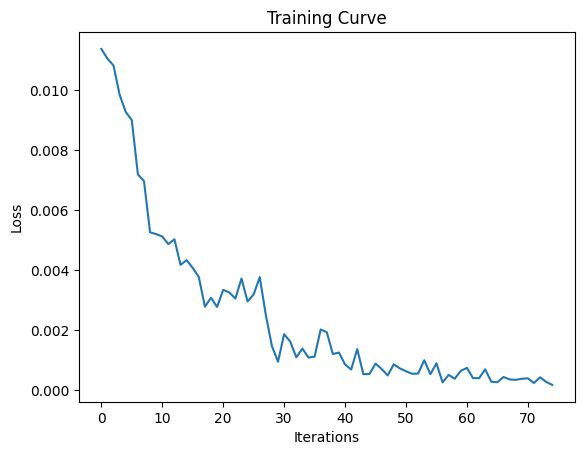

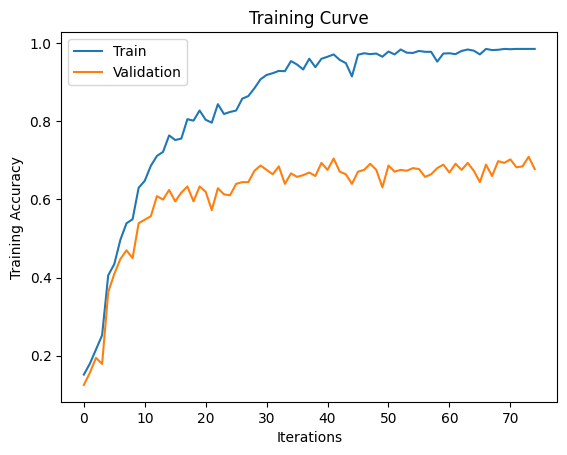

Final Training Accuracy: 0.9851961509992598
Final Validation Accuracy: 0.6778523489932886


In [ ]:
#For GPU Usage
use_cuda = True
model = CNNClassifier()
if use_cuda and torch.cuda.is_available():
  model.cuda()
else:
  print('CUDA is not available')

#Starting with a Default Model
train(model, train_data, val_data, learning_rate = 0.001, batch_size = 200, num_epochs = 75)

In [ ]:
#For GPU Usage
use_cuda = True
model = CNNClassifier()
if use_cuda and torch.cuda.is_available():
  model.cuda()
else:
  print('CUDA is not available')

#Starting with a Default Model
train(model, train_data, val_data, learning_rate = 0.01, batch_size = 400, num_epochs = 200)

NameError: ignored

### Part (c) - 2 pt
Choose the best model out of all the ones that you have trained. Justify your choice.

### Part (d) - 2 pt
Report the test accuracy of your best model. You should only do this step once and prior to this step you should have only used the training and validation data.

### 4. Transfer Learning [15 pt]
For many image classification tasks, it is generally not a good idea to train a very large deep neural network
model from scratch due to the enormous compute requirements and lack of sufficient amounts of training
data.

One of the better options is to try using an existing model that performs a similar task to the one you need
to solve. This method of utilizing a pre-trained network for other similar tasks is broadly termed **Transfer
Learning**. In this assignment, we will use Transfer Learning to extract features from the hand gesture
images. Then, train a smaller network to use these features as input and classify the hand gestures.

As you have learned from the CNN lecture, convolution layers extract various features from the images which
get utilized by the fully connected layers for correct classification. AlexNet architecture played a pivotal
role in establishing Deep Neural Nets as a go-to tool for image classification problems and we will use an
ImageNet pre-trained AlexNet model to extract features in this assignment.

### Part (a) - 5 pt
Here is the code to load the AlexNet network, with pretrained weights. When you first run the code, PyTorch
will download the pretrained weights from the internet.

In [ ]:
import torchvision.models
alexnet = torchvision.models.alexnet(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:03<00:00, 77.7MB/s]


The alexnet model is split up into two components: *alexnet.features* and *alexnet.classifier*. The
first neural network component, *alexnet.features*, is used to compute convolutional features, which are
taken as input in *alexnet.classifier*.

The neural network alexnet.features expects an image tensor of shape Nx3x224x224 as input and it will
output a tensor of shape Nx256x6x6 . (N = batch size).

Compute the AlexNet features for each of your training, validation, and test data. Here is an example code
snippet showing how you can compute the AlexNet features for some images (your actual code might be
different):

In [ ]:
# img = ... a PyTorch tensor with shape [N,3,224,224] containing hand images ...
features = alexnet.features(img)

**Save the computed features**. You will be using these features as input to your neural network in Part
(b), and you do not want to re-compute the features every time. Instead, run *alexnet.features* once for
each image, and save the result.

### Part (b) - 3 pt
Build a convolutional neural network model that takes as input these AlexNet features, and makes a
prediction. Your model should be a subclass of nn.Module.

Explain your choice of neural network architecture: how many layers did you choose? What types of layers
did you use: fully-connected or convolutional? What about other decisions like pooling layers, activation
functions, number of channels / hidden units in each layer?

Here is an example of how your model may be called:

In [ ]:
# features = ... load precomputed alexnet.features(img) ...
output = model(features)
prob = F.softmax(output)

### Part (c) - 5 pt
Train your new network, including any hyperparameter tuning. Plot and submit the training curve of your
best model only.

Note: Depending on how you are caching (saving) your AlexNet features, PyTorch might still be tracking
updates to the **AlexNet weights**, which we are not tuning. One workaround is to convert your AlexNet
feature tensor into a numpy array, and then back into a PyTorch tensor.

In [ ]:
tensor = torch.from_numpy(tensor.detach().numpy())

### Part (d) - 2 pt
Report the test accuracy of your best model. How does the test accuracy compare to Part 3(d) without transfer learning?

### 5. Additional Testing [5 pt]
As a final step in testing we will be revisiting the sample images that you had collected and submitted at the start of this lab. These sample images should be untouched and will be used to demonstrate how well your model works at identifying your hand guestures.

Using the best transfer learning model developed in Part 4. Report the test accuracy on your sample images and how it compares to the test accuracy obtained in Part 4(d)? How well did your model do for the different hand guestures? Provide an explanation for why you think your model performed the way it did?